In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from advertorch.attacks import GradientSignAttack

D:\software\anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\software\anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\software\anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
D:\software\anaconda\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
NORMALIZE = False
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if NORMALIZE:
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
else:
    trans = transforms.Compose([
        transforms.ToTensor(),
    ])
    
data_home = './'

train_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'),train=True, download=True,transform=trans)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=64, shuffle=True,num_workers=2)
test_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'),
                                        train=False, download=True,transform=trans)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=64, shuffle=False,num_workers=2)


# 显示数据集

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


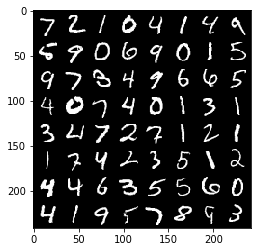

In [4]:
def imshow(img):
    if NORMALIZE:
        img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))

dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(labels)

# LeNet模型

In [13]:
# 新手写法
# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.fc1 = nn.Linear(16*5*5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
        
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# # 花里胡哨写法
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1,6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classify = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84,10)
        )
    
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# 开始训练

In [14]:
def run_training(model, lr, epochs, train_loader, test_loader):
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        for bat_nums, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            print('\r bat_nums: {}'.format(bat_nums), end='')
            
        # test
        model.eval()
        correct = 0
        count = 0
        for bat_num, (data, target) in enumerate(test_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
        print('epoch: {}, correct: {}'.format(epoch, correct/count))

In [15]:
lr = 0.01
epochs = 10
epsilon = 0.3

In [16]:
model = LeNet()
model = model.to(DEVICE)

In [17]:
run_training(model, lr, epochs, train_loader, test_loader)

 bat_nums: 937epoch: 0, correct: 0.978
 bat_nums: 937epoch: 1, correct: 0.9809
 bat_nums: 937epoch: 2, correct: 0.9785
 bat_nums: 937epoch: 3, correct: 0.9834
 bat_nums: 937epoch: 4, correct: 0.9809
 bat_nums: 937epoch: 5, correct: 0.9807
 bat_nums: 937epoch: 6, correct: 0.9827
 bat_nums: 937epoch: 7, correct: 0.984
 bat_nums: 937epoch: 8, correct: 0.98
 bat_nums: 937epoch: 9, correct: 0.9813


In [18]:
attacks = GradientSignAttack(model, eps=epsilon)
images_purb = attacks.perturb(images.to(DEVICE))

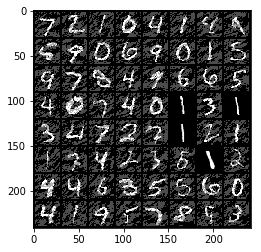

In [19]:
imshow(torchvision.utils.make_grid(images_purb.detach().cpu()))